# Jupyter notebooks on Arc

Run code on westgrid, access from any browser

In [1]:
# Step 1: You can run linux commands - useful for e.g. installing custom dependencies
!pip install --user -U --force-reinstall --no-deps "git+https://github.com/padster/pyNeuroTrace#egg=pyneurotrace&subdirectory=pyneurotrace"

  Cloning https://github.com/padster/pyNeuroTrace to /tmp/pip-install-tfc7c859/pyneurotrace
  Running command git clone -q https://github.com/padster/pyNeuroTrace /tmp/pip-install-tfc7c859/pyneurotrace
  Created wheel for pyneurotrace: filename=pyneurotrace-0.0.1-cp37-none-any.whl size=20778 sha256=0af25f37e3af45f9b297319df9b8fc0d91d386e7723fd2ddc8a7fa32bac00fb1
  Stored in directory: /tmp/pip-ephem-wheel-cache-gtevrpkt/wheels/8c/47/19/97a7066678a73a6f24f8f459bc8cab75efa6b1fd8debcb335b
Successfully built pyneurotrace
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Load a bunch of python libraries
import os
import numpy as np
import pandas as pd
import pyneurotrace.notebook as pyntNB

### Loading data

Files can be stored on your own drive, or in a folder shared with your lab.

In [3]:
# Shared lab folder:
SHARED_FOLDER = '/alder/data/cbh/haas-data/'

# Load all the rows into a pandas dataframe, and print some example rows:
DATASET = pd.read_csv(os.path.join(SHARED_FOLDER, "tadpoleTracker", "data.csv"))
display(DATASET.sample(10))

# Show all the behaviour stages:
STAGES = DATASET.seizureStage.unique()
print ("Stages identified:\n\t%s" % str(STAGES))

,D1 b,D1 s,D2 b,D2 s,seizureStage,D1 b (%),D1 s (%),D2 b (%),D2 s (%),tadpole,stim,experiment
130,0,492,9635,649,bStill,0.000000,3.209393,58.674868,2.548096,R1C2,WN,exp4
315,1875,1709,605,4036,Class V,13.490179,4.753693,2.986180,11.513008,R1C2,WN,exp8
111,1080,5761,932,5577,Class V,5.135276,16.835184,5.001342,16.937468,R3C1,CP,exp4
75,323,2388,853,2662,Class V,3.455285,9.514702,5.837668,10.614882,R3C1,WN,exp3
291,605,1726,818,4232,Class V,7.657259,8.017838,4.847120,11.708397,R2C1,CP,exp8
367,11016,9172,4281,9936,Class II,55.935818,24.297332,24.187807,29.586398,R3C2,CP,exp9
97,3311,3784,2001,5852,Class II,49.902035,20.409924,41.223733,32.904133,R2C1,CP,exp4
186,620,6925,1234,6093,Class I,3.057802,21.825459,8.241501,22.358813,R1C1,WN,exp5
182,1924,5860,1155,5302,Class IV,9.845461,20.712569,8.248822,17.322835,R3C2,CP,exp5
113,2156,6594,1047,7582,bMove,10.251533,19.269433,5.618460,23.026695,R3C1,CP,exp4


Stages identified:
	['Class I' 'Class II' 'Class IV' 'Class V' 'bStill' 'bMove']


### Plotting data

All normal plotting libraries should be available.
Note that many require some initial configuration, and some will let you interact

**Visualization using matplotlib/seaborn:**

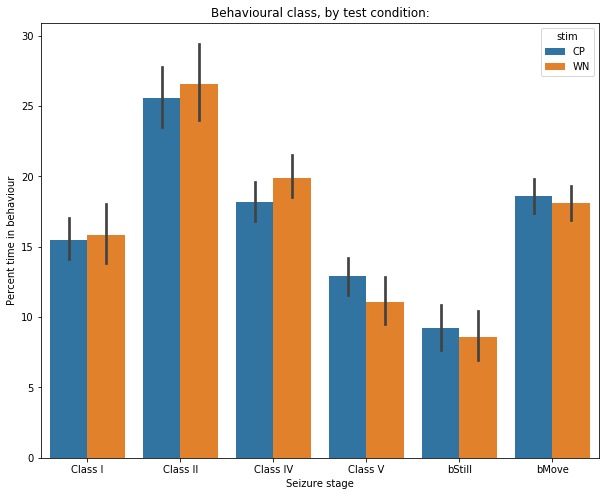

Graph saved to classByCondition.png


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8)

# Seaborn example:
ax = sns.barplot(data=DATASET, x="seizureStage", y="D1 s (%)", hue="stim")
ax.set_title("Behavioural class, by test condition:")
ax.set_xlabel("Seizure stage")
ax.set_ylabel("Percent time in behaviour")

graphPath = "classByCondition.png"
plt.savefig(graphPath)

plt.show()
print ("Graph saved to %s" % graphPath);

**Bokeh example for interactive plotting**

A bit more complicated to set up, but much nicer interaction

In [5]:
# Bokeh interactive example:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.palettes import Spectral5
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

output_notebook()

colors = factor_cmap('stim', palette=Spectral5, factors=sorted(DATASET.stim.unique()))

p = figure(plot_width=600, plot_height=600)
p.circle(x='D1 s (%)', y='D2 s (%)', line_color=colors, fill_color=colors, source=ColumnDataSource(DATASET), size=8)
p.title.text = 'Percentage by class'
p.xaxis.axis_label = 'Day 1 post-seizure %'
p.yaxis.axis_label = 'Day 2 post-seizure %'
p.add_tools(HoverTool(tooltips=[('stim', '@stim'), ('tadpole', '@tadpole')]))
show(p)

Loading BokehJS ...

### Running Analysis

You can run any type of computational analysis - e.g. pre/post-processing, outlier removal, statistical tests, ...

In [6]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from scipy.stats import ks_2samp
import time

RESULTS = pd.DataFrame(index=STAGES)

def showStimResponse(_, __, stimType):
    stimData = DATASET[DATASET.stim == stimType]
    print ("%d/%d rows have stim %s" % (stimData.shape[0], DATASET.shape[0], stimType))
    
    cleanData = stimData[['D1 s (%)', 'D2 s (%)', 'seizureStage']].melt(
        id_vars='seizureStage', var_name='Day', value_name='Percentage')   
    sns.barplot(data=cleanData, x="seizureStage", y="Percentage", hue="Day")
    plt.show()
    
    for stage in STAGES:
        stageData = cleanData[cleanData.seizureStage == stage]
        day1Data = stageData[stageData.Day == 'D1 s (%)'].Percentage.values
        day2Data = stageData[stageData.Day == 'D2 s (%)'].Percentage.values
        kolmogorovSmirnov = ks_2samp(day1Data, day2Data)
        print ("Comparison for %s:    \t%s" % (stage, kolmogorovSmirnov))
        RESULTS.loc[stage, stimType] = kolmogorovSmirnov.pvalue
        
    # Slow it down to make the progress bar visible
    time.sleep(7)

pyntNB.showTabs(['CP', 'WN'], showStimResponse, titles=['CP', 'WN'], progressBar=True)

### Writing data to file

Any results or images can be saved to file and downloaded, for plotting / excel / ...

In [7]:
print ("p-values: ")
display(RESULTS)

resultFile = "acrossDayPValues.csv"
RESULTS.to_csv(resultFile)
print ("Written to %s" % resultFile)

p-values: 


,CP,WN
Class I,0.013193,0.013193
Class II,0.105686,0.002356
Class IV,0.976192,0.672684
Class V,0.672684,0.863227
bStill,0.672684,0.976192
bMove,0.672684,0.105686


Written to acrossDayPValues.csv
